# Preparing the dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedadlyi/aflw2000-3d")

100%|██████████| 83.4M/83.4M [00:01<00:00, 77.2MB/s]

Extracting files...


In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 16.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import cv2
import math
import glob
import random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe as mp
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [ ]:
img_list = [img for img in os.listdir(path+'/AFLW2000') if img.endswith(".jpg") ]

In [ ]:
len(img_list)

2000

In [ ]:
facelib = mp.solutions.face_mesh

# Preprocessing

In [ ]:
# Lists to store data
images = []
mask_values = []
pitch = []
yaw = []
roll = []

# Iterate over image files
with facelib.FaceMesh(static_image_mode=True) as faces:

    for i, img in enumerate(img_list):
      c_file = path+'/AFLW2000/'+img
      image = cv2.imread(c_file)
      if image is None:
          print(f'Failed to load file {c_file.split("AFLW2000")[-1]}')
          continue

      mat_file = c_file.replace('jpg', 'mat')
      mat_file = sio.loadmat(mat_file)
      if mat_file is None:
          print(f'Failed to load file {mat_file.split("AFLW2000")[-1]}')
          continue

      # Convert the image to RGB format (required for Mediapipe)
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Process the image to extract landmark points
      results = faces.process(image_rgb)

      if results.multi_face_landmarks is None :
          continue

      # Extract x and y values from results
      height, width = image_rgb.shape[:2]

      x_val = [lm.x*width  for lm in results.multi_face_landmarks[0].landmark]
      y_val = [lm.y*height  for lm in results.multi_face_landmarks[0].landmark]

      # centering around the nose landmark
      x_val = np.array(x_val)-np.mean(x_val[1])
      y_val = np.array(y_val)- np.mean(y_val[1])

      # normalizing based on the average distance from chin to head and from ear to ear
      x_val = x_val / x_val.max()
      y_val = y_val / y_val.max()


      # Extract labels from mat file
      pose_para = mat_file["Pose_Para"][0][:3]
      p, y, r = pose_para[0], pose_para[1], pose_para[2]

      # Append values to lists
      mask_values.append(np.concatenate([x_val,y_val]))
      pitch.append(p)
      yaw.append(y)
      roll.append(r)
      images.append(c_file.split("image")[-1].split('.')[0][1:])

# Create DataFrame
data = {
    'Image_Id': images,
    'marks_Values': mask_values,
    'Pitch': pitch,
    'Yaw': yaw,
    'Roll': roll
}
data
df = pd.DataFrame(data)

In [ ]:
df.head()

,Image_Id,marks_Values,Pitch,Yaw,Roll
0,3692,"[0.04339683909452024, 0.0, 0.05656647275648681...",-0.411350,0.453901,-0.021469
1,3783,"[-0.1258506660465659, 0.0, -0.0897633757519132...",0.127275,-0.297182,0.174667
2,1109,"[0.09232820698332561, 0.0, 0.07152835973913037...",-0.052379,0.456169,-0.082544
3,2440,"[0.054388319496758084, 0.0, 0.0937634480884116...",0.679802,1.260817,0.720205
4,4092,"[0.03394005535064242, 0.0, 0.02622485311313410...",-0.123426,0.110478,-0.000255


In [ ]:
def map_to_pi(angle):
    """
    Maps an angle to the range [-π, π].
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [ ]:
df[['Pitch', 'Yaw', 'Roll']] = df[['Pitch', 'Yaw', 'Roll']].apply(map_to_pi)

In [ ]:
df.head()

,Image_Id,marks_Values,Pitch,Yaw,Roll
0,3692,"[0.04339683909452024, 0.0, 0.05656647275648681...",-0.411350,0.453901,-0.021469
1,3783,"[-0.1258506660465659, 0.0, -0.0897633757519132...",0.127275,-0.297182,0.174667
2,1109,"[0.09232820698332561, 0.0, 0.07152835973913037...",-0.052379,0.456169,-0.082544
3,2440,"[0.054388319496758084, 0.0, 0.0937634480884116...",0.679802,1.260817,0.720205
4,4092,"[0.03394005535064242, 0.0, 0.02622485311313410...",-0.123426,0.110478,-0.000255


In [ ]:
X = np.array(df['marks_Values'].to_list())
y = np.array(df[['Pitch', 'Yaw', 'Roll']])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X.shape, y.shape)

(1853, 936) (1853, 3)


# Training the model

In [ ]:
regressor = SVR(kernel='rbf',C=3,gamma=0.005,degree=3,epsilon=0.005)
model = MultiOutputRegressor(regressor)

# Train the multi-output regression model
model.fit(X_train, y_train)

predictions = model.predict(X_test)

# Validating the model

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import pickle

In [ ]:
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
print(f'r2_score is : {r2_score(y_test, predictions)}')

Mean Squared Error: 0.026440939195943296
r2_score is : 0.7516447903570344


# Testing the model

In [ ]:
model_name = 'face_vector_model.sav'
pickle.dump(model, open(model_name, 'wb'))

In [ ]:
loaded_model = pickle.load(open('face_vector_model.sav', 'rb'))

In [ ]:
type(loaded_model)

sklearn.multioutput.MultiOutputRegressor

In [ ]:
def preprocess(file):
  with facelib.FaceMesh(static_image_mode=True) as faces:
    image = cv2.imread(file)
    if image is None:
        print(f'Failed to load file {file}')
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = faces.process(image_rgb)

    if results.multi_face_landmarks is None :
      print('no faces detected')

    height, width = image_rgb.shape[:2]

    x_val = [lm.x*width  for lm in results.multi_face_landmarks[0].landmark]
    y_val = [lm.y*height  for lm in results.multi_face_landmarks[0].landmark]

    # centering around the nose landmark
    x_val = np.array(x_val)-np.mean(x_val[1])
    y_val = np.array(y_val)- np.mean(y_val[1])

    # normalizing based on the average distance from chin to head and from ear to ear
    x_val = x_val / x_val.max()
    y_val = y_val / y_val.max()
    return np.concatenate([x_val, y_val])

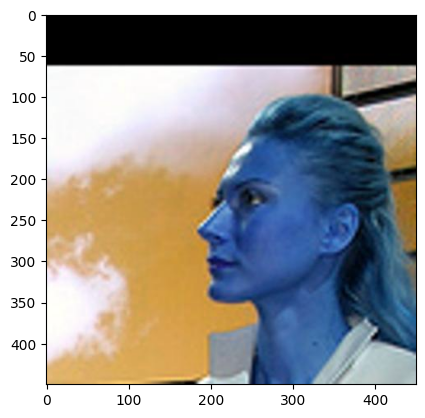

In [ ]:
plt.imshow(cv2.imread(path+'/AFLW2000/image00004.jpg'))

In [ ]:
preprocessed_img = preprocess(path+'/AFLW2000/image00004.jpg')

In [ ]:
loaded_model.predict(preprocessed_img.reshape(1,-1))

array([[0.06321692, 1.14147924, 0.05112095]])